In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import decomposition
import numpy as np
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pickle

import seaborn as sns

In [22]:
def get_data(path, remove_irrelevant=True):
    data = pd.read_csv(path)
    if remove_irrelevant:
        del data['number_sta']
        del data['Id']
        # del data['hour']
        del data['latitude']
        del data['longitude']
        del data['height_sta']
        del data['ground_truth']
    del data['date']
    del data['timestamp']
    print(data.columns.tolist())
    return data

def get_data_forecast(path):
    data = pd.read_csv(path)
    del data['Id']
    del data['station_id']
    del data['altitude (m)']
    del data['latitude']
    del data['longitude']
    del data['latitude_idx']
    del data['longitude_idx']
    del data['month_cos']
    del data['month_sin']
    del data['day']
    return data

def get_barycenter_per_months(data, normalize = True):
    barycenters = pd.DataFrame(columns=data.columns)
    col = np.array(data.columns)
    col = col[col != 'month']
    if normalize :
        data[col] = MinMaxScaler().fit_transform(data[col])
    for i in range(12):
        row = []
        for column in barycenters.columns :
            if column == 'month':
                row.append(i+1)
            else :
                row.append(data[data['month']==i+1][column].mean())
        barycenters.loc[len(barycenters.index)] = row
    return  barycenters

def eval_clustering(barycenters):
    column_except_month_cluster = np.array(barycenters.columns)
    column_except_month_cluster = column_except_month_cluster[column_except_month_cluster != 'month']
    silhouette_result = []
    ch_score_result = []
    for k in range(2,12):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(barycenters[column_except_month_cluster])
        print(k, kmeans.labels_)

        barycenters['cluster'] = kmeans.labels_

        silhouette = silhouette_score(barycenters[column_except_month_cluster], barycenters['cluster'])
        silhouette_result.append(silhouette)
        ch_score = calinski_harabasz_score(barycenters[column_except_month_cluster], barycenters['cluster'])
        ch_score_result.append(ch_score)

    return silhouette_result, ch_score_result

def get_normalization_infos(*x_s, columns):
    normalization_infos = pd.DataFrame(data=[[1000 for _ in range(len(columns))],[0 for _ in range(len(columns))]],
                                       index=["min","max"],
                                       columns=columns)
    for x in x_s :
        for col in columns:
            min_value = min(normalization_infos[col]["min"], x[col].min())
            max_value = max(normalization_infos[col]["max"], x[col].max())
            normalization_infos[col] = [min_value, max_value]

    normalization_infos.loc["spread"] = normalization_infos.apply(lambda c : c["max"] - c["min"], axis=0)

    return normalization_infos


def normalize(x : pd.DataFrame, normalization_infos : pd.DataFrame):
    for col in x.columns:
        x[col] = (x[col] - normalization_infos[col]["min"])/normalization_infos[col]["spread"]
    return x

# Clustering on dataset with forecasting

2 [1 1 1 1 0 0 0 0 0 0 1 1]
3 [1 1 1 1 0 2 2 2 2 0 1 1]
4 [1 1 1 1 2 0 0 0 0 2 3 3]
5 [1 1 3 3 0 2 2 2 2 0 4 4]
6 [1 1 4 4 2 5 0 0 5 2 3 3]
7 [3 3 2 2 6 0 5 5 0 4 1 1]
8 [2 2 4 4 6 0 5 5 0 3 1 7]
9 [2 2 8 4 6 0 5 5 0 3 1 7]
10 [2 9 8 4 6 0 5 5 0 3 1 7]
11 [ 2  9  8  4  6  0  5  5 10  3  1  7]


<AxesSubplot:xlabel='Value of k', ylabel='Silhouette score'>

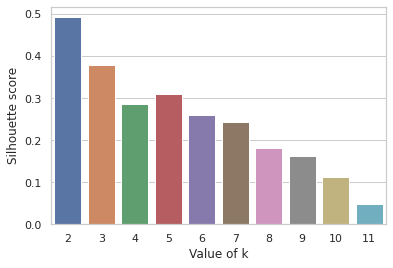

KeyboardInterrupt: 

In [28]:
path_2016 = './preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final_by_day.zip'
path_2017 = './preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final_by_day.zip'

data_2016 = get_data_forecast(path_2016)
data_2017 = get_data_forecast(path_2017)
data = data_2016.append(data_2017, ignore_index = True)

barycenters = get_barycenter_per_months(data, True)

k_values = np.arange(2,12)
silhouette_result, ch_score_result = eval_clustering(barycenters)

silhouette_data_to_show = pd.DataFrame({'Value of k' : k_values, 'Silhouette score' : silhouette_result})
ch_score_data_to_show = pd.DataFrame({'Value of k' : k_values, 'C-H score' : ch_score_result})

sns.set_theme(style="whitegrid")
sns.barplot(x="Value of k", y="Silhouette score", data=silhouette_data_to_show)

# Clustering on dataset X_station

['wind_speed', 'temperature', 'dew_point', 'humidity', 'wind_direction', 'precip', 'month']
2 [1 1 1 1 0 0 0 0 0 1 1 1]
3 [1 1 1 2 2 0 0 0 0 2 1 1]
4 [1 1 2 2 3 0 0 0 0 3 1 1]
5 [1 1 3 3 4 2 2 2 4 0 1 1]
6 [0 5 3 3 1 4 4 4 1 2 5 0]
7 [3 5 1 1 0 6 2 2 6 4 5 3]
8 [4 1 3 6 0 5 2 2 5 7 1 4]
9 [0 6 3 7 2 4 8 1 4 5 6 0]
10 [0 9 6 2 8 1 4 7 1 3 5 0]
11 [10  2  9  0  3  6  7  1  6  4  8  5]


<AxesSubplot:xlabel='Value of k', ylabel='Silhouette score'>

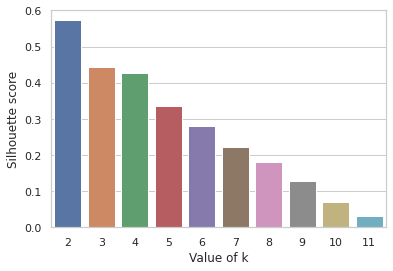

In [26]:
path ='./preprocessed_data_Defi-IA-2022-Rain-Frogs/X_station_coord_2nn_imputed_by_day.csv'
data = get_data(path)

barycenters = get_barycenter_per_months(data, True)

k_values = np.arange(2,12)
silhouette_result, ch_score_result = eval_clustering(barycenters)

silhouette_data_to_show = pd.DataFrame({'Value of k' : k_values, 'Silhouette score' : silhouette_result})
ch_score_data_to_show = pd.DataFrame({'Value of k' : k_values, 'C-H score' : ch_score_result})

sns.set_theme(style="whitegrid")
sns.barplot(x="Value of k", y="Silhouette score", data=silhouette_data_to_show)

**Petit dataset**
- Avec normalisation
Cluster 1 : Janvier Mars Avril
Cluster 2 : Février Novembre Décembre
Cluster 3 : Mai Août Octobre
Cluster 4 : Juin Juillet Septembre
```{1: 0, 2: 3, 3: 0, 4: 0, 5: 2, 6: 1, 7: 1, 8: 2, 9: 1, 10: 2, 11: 3, 12: 3}```

- Sans normalisation
Cluster 1 : Janvier Février Mars Avril Mai Octobre Novembre Décembre
Cluster 2 : Juin Juillet Août Septembre
```{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1}```

**Gros dataset**
- Sans normalisation
Cluster 1 : Janvier Février Mars Novembre
Cluster 2 : Avril
Cluster 3 : Mai Juin Juillet Août Septembre Octobre Décembre
```{1: 2, 2: 2, 3: 2, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 2, 12: 0}```

- Avec normalisation
Cluster 1 : Janvier Février Mars Avril Novembre Décembre
Cluster 2 : Mai Juin Juillet Août Septembre Octobre
```{1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1}```
